# Additive model with PyMC3

Here we present a model with more detail, where the distribution of the overall delay is determined by the sum of individual delays. 

This creates a model with more detail, but requires more workarounds as we have to model the discreteness in the system - the sum of delays will be affected by whether the order has queued or not. Also, the model is more biased compared to the high-level one - cost of adding high level detail. See the discrepancy between the observed vs posterior distributions below.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np
import scipy.stats as st

%matplotlib inline

# Load data


In [2]:
DATA_DIR = '../data'

In [3]:
df = pd.read_csv(f'{DATA_DIR}/input_data.csv')

In [4]:
df['total_time_to_me'] = df['reaction_time'] + df['time_to_me']

/home/frix_p_au_core_util_ipynb02/.anaconda/envs/perf_p36/lib/python3.6/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/home/frix_p_au_core_util_ipynb02/.anaconda/envs/perf_p36/lib/python3.6/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


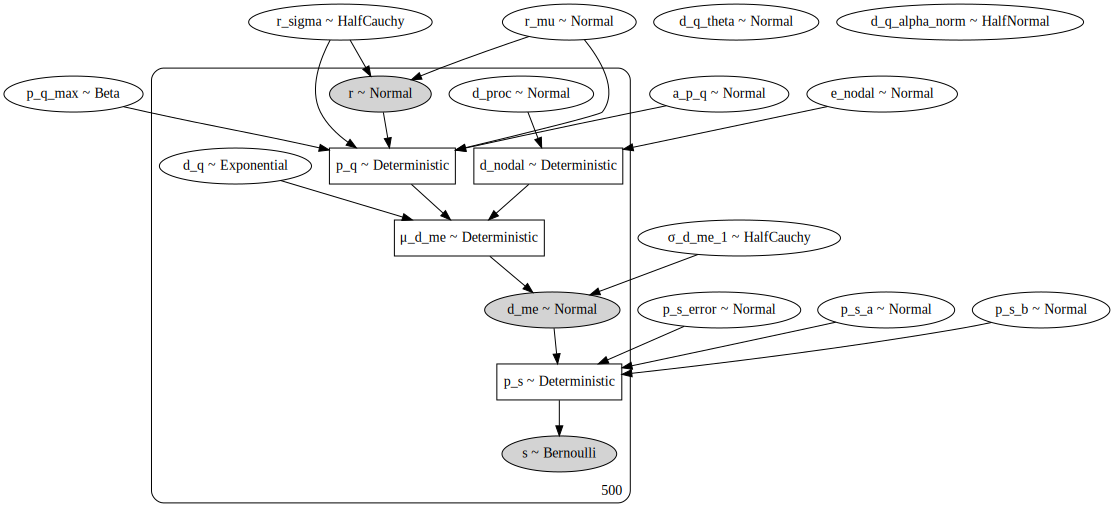

In [5]:
mean_delay = 4440
std_delay = 100

N = 500
success_batches = pm.Minibatch(df.success.values, batch_size=N)
reaction_time = pm.Minibatch(df.reaction_time.values.astype(float), batch_size=N)

time_to_me_batch = pm.Minibatch(df.time_to_me.values.astype(float), batch_size=N)
time_to_me_shifted_batch = pm.Minibatch(df.time_to_me.astype(float).values-mean_delay, batch_size=N)

mean_reaction_time = 600
std_reaction_time = 25
best_reaction_time = 100

import theano.tensor as tt
from theano import shared

with pm.Model() as model_delay_hierarchical:     
    # Reaction time
    r_mu = pm.Normal('r_mu', mu=mean_reaction_time, sigma=10)    
    r_sigma = pm.HalfCauchy('r_sigma', beta=std_reaction_time)
    reaction_time_obs = pm.Normal('r', mu=r_mu, sigma=r_sigma, observed=reaction_time)
    
    # Nodal delays
    ## Propagation delay
    t_p1 = 1000  # Propagation delay - participant -> switch 1
    t_p2 = 500 # Propagation delay - switch 1 -> switch 2
    t_me = 1000 # Propagation delay - switch2 -> me
    
    ## Processing delay
    processing_delay_var = pm.Normal('d_proc',shape=N)
    sigma_proc = 50 * np.sqrt(2)
    processing_delay_mean = 970*2
    processing_delay = processing_delay_var*sigma_proc+processing_delay_mean    
        
    ## Sum of all above, total delay when there is no queuing
    delay_error = pm.Normal('e_nodal', mu=0, sigma=10)
    
    total_nodal_delay = pm.Deterministic('d_nodal', var=t_p1+t_p2+t_me+processing_delay+delay_error)
    
    
    # Bursts and queuing
   
    ## Queuing delay
    packet = 138
    alpha_base = 10
    d_q_theta = pm.Normal('d_q_theta', mu=packet/2, sigma=25)
    d_q_alpha = pm.HalfNormal('d_q_alpha_norm', sigma=1)
    queuing_delay = pm.Gamma('d_q', alpha=alpha_base+d_q_alpha, beta=1/d_q_theta, shape=N)
        
    
    ## Probability of queuing
    
    reaction_rate = (reaction_time_obs / best_reaction_time)
    reaction_time_z = (reaction_time_obs - r_mu) / r_sigma
    a_p_q = pm.Normal('a_p_q',mu=0, sd=1)
    p_q_max = pm.Beta('p_q_max', alpha=.3, beta=.7)
    
    p_q = pm.Deterministic('p_q', var= pm.invlogit(reaction_time_z+a_p_q)*p_q_max    )
    

    
    # Time to matching engine   
    queing_delay_shape = 20
    queing_delay_factor = pm.invlogit(queing_delay_shape*(p_q-0.5)) # A continuous 'step-function', a workaround to avoid discrete variables
    
    μ_d_me = pm.Deterministic(name='μ_d_me', var=total_nodal_delay+queing_delay_factor*queuing_delay)
    σ_d_me_1 = pm.HalfCauchy(name='σ_d_me_1', beta=5)
    time_to_me_obs = pm.Normal(name='d_me', observed=time_to_me_batch, mu=μ_d_me, sigma =σ_d_me_1,  shape=N )
    
    # Success
    a_p_s = pm.Normal('p_s_a')
    b_p_s = pm.Normal('p_s_b')
    error_p_s = pm.Normal('p_s_error')
    sigma_error_p_s = 1
    
    
    p_s = pm.Deterministic(name='p_s', var=pm.invlogit(error_p_s*sigma_error_p_s+(a_p_s+1)*((time_to_me_obs+reaction_time)/5000)+b_p_s))      
    success = pm.Bernoulli(name='s', observed=success_batches, p=p_s)
    

pm.model_to_graphviz(model_delay_hierarchical)

In [7]:
with model_delay_hierarchical:
  approx = pm.fit(method='svgd', n=1000, inf_kwargs={'n_particles': 100}) # callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')]

100%|██████████| 1000/1000 [01:52<00:00,  7.11it/s]


In [8]:
sample = approx.sample(10000)

In [9]:
sample_stats = pm.stats.summary(sample, 
                                varnames=['r_mu', 'r_sigma', 'σ_d_me_1', 'd_q_alpha_norm', 'd_q_theta', 'e_nodal', 'p_q_max',
                                         'a_p_q', 'p_s_error'])

p_q_mean=approx.sample_node(p_q, size=10000).eval().mean()
print (f'Overall probability of queuing: {p_q_mean}')

sample_stats

Overall probability of queuing: 0.10521871586577189


,mean,sd,mc_error,hpd_2.5,hpd_97.5
r_mu,600.367499,0.979816,0.010100,598.871009,602.494734
r_sigma,43.550005,42.003534,0.353087,2.462551,137.336786
σ_d_me_1,10.585042,9.416110,0.089959,0.986951,27.329103
d_q_alpha_norm,0.979028,1.033128,0.010524,0.045859,2.988556
d_q_theta,69.039138,1.092338,0.011572,66.686320,70.764282
e_nodal,0.430676,0.841247,0.007839,-1.055493,2.044130
p_q_max,0.258581,0.159219,0.001606,0.025896,0.545590
a_p_q,-0.503705,1.030155,0.009417,-2.242420,1.686837
p_s_error,0.005900,0.866586,0.007311,-1.473183,1.747726


In [21]:
with model_delay_hierarchical:
  ppc = pm.sample_posterior_predictive(sample,samples=100)
  


100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


In [22]:
ppc_time_to_me = ppc['d_me'].flatten()

Text(0.5, 1.0, 'Time to matching engine')

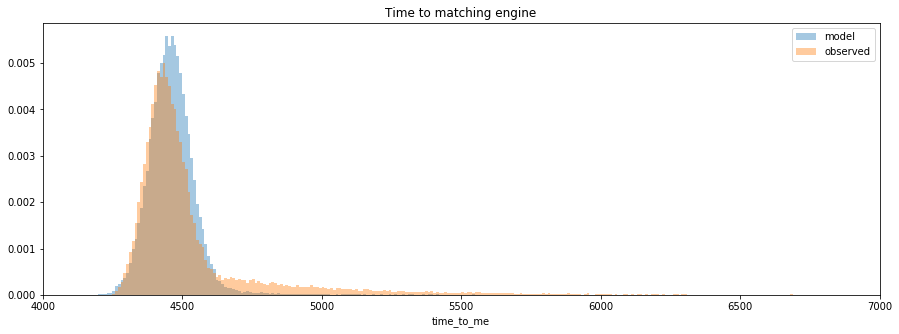

In [23]:
plt.figure(figsize=[15, 5])
sns.distplot(ppc_time_to_me, kde=False, norm_hist=True, bins=np.arange(0, 8000, 10), label='model')
sns.distplot(df.time_to_me, kde=False, norm_hist=True, bins=np.arange(0, 8000, 10), label= 'observed')
plt.xlim([4000, 7000])
plt.legend()

plt.title('Time to matching engine')